# Multi-Armed Bandits

Do you have a favourite coffee place in town? When you feel the need to replenish your caffeine levels, chances are you will choose to get a coffee from your favourite coffee place, as you are almost sure that you will get the best coffee or at least closer to your subjective preferences. This however means that you may be missing out on the delicious coffee served by this new place two blocks away. And if you were to try out all the coffee places one by one, the probability of having the worse coffee of your life would be pretty high! But then again, there’s a chance you’ll find an even better coffee brewer. 

The dilemma in our coffee tasting experiment arises from incomplete information. Put it differently, it is important to gather enough information in order to formulate the best overall strategy and then explore new actions. This will eventually lead to minimizing the overall bad experiences.

A multi-armed bandit is a simplified form of this analogy. It is used to represent similar kinds of problems and finding a good strategy to solve them is already helping a lot of industries. In this Python notebook, we will explore some strategies on how to solve the multi armed bandit problem.

![robot](img/robot.png)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

## 1. The general bandit algorithm

Here we declare a general bandit algorithm that accepts various initialization, action selection and update strategies.

In [2]:
def bandit(bandit_inputs, seed=1):
    
    # Unpacking the bandit inputs:
    k = bandit_inputs["k"]
    N = bandit_inputs["N"]
    q_star = bandit_inputs["q_star"]
    initialization = bandit_inputs["initialization"]
    action_selection = bandit_inputs["action_selection"]
    update_rule = bandit_inputs["update_rule"]
    
    #Initializing rewards and regret
    total_reward = 0
    mean_reward = 0
    mean_rewards = np.zeros(N)
    regret = np.zeros(N)
    
    # Initialize the estimates
    np.random.seed(seed)
    estimates = initialization(k, q_star)
    for t in range(1,N+1):
        np.random.seed(seed*t) #we need this because random init changes the order later on
        # Select a coffee shop
        coffee_shop = action_selection(estimates, bandit_inputs, t)
    
        # Update action counter
        bandit_inputs["k_t"][coffee_shop] += 1
    
        # Get reward
        reward = np.random.normal(q_star[coffee_shop], 1)
        
        # Update the total reward
        total_reward += reward
        
        # Calculate mean reward and regret
        mean_reward = mean_reward + (reward - mean_reward) / t
        mean_rewards[t-1] = mean_reward
        #regret[t-1] = t * mean_rewards[np.argmax(mean_rewards[0:t])] - total_reward
        regret[t-1] = np.max(q_star) - reward # True maximum! We do not know it but, why not? :)
        #if regret[t-1]<0:
            #print("what?")
        
        estimates = update_rule(estimates, coffee_shop, reward, bandit_inputs, mean_reward)
        
    return estimates, total_reward, mean_rewards, regret

## 1.1. Initialization strategies
Using the q* values, we create initialization methods that implement zero, pessimistic, average, optimistic and random estimate initializations for the bandit algorithm:

#### Estimate initialization with zeroes:

In [3]:
def ZeroInitialization(k, q_star):
    # Zero initialization
    return np.zeros(k)

#### Pessimistic estimate initialization:

In [4]:
def MinInitialization(k, q_star):
    # Min initialization
    return np.ones(k) * np.min(q_star)

#### Mean estimate initialization:

In [5]:
def MeanInitialization(k, q_star):
    # Mean initialization
    return np.ones(k) * np.mean(q_star)

#### Optimistic estimate initialization:

In [6]:
def MaxInitialization(k, q_star):
    # Max initialization
    return np.ones(k) * np.max(q_star)

#### Estimate initialization with random numbers:

In [7]:
def RandomInitialization(k, q_star):
    # Random initialization
    return np.random.normal(0, 1, k)  #let's assume we know the distributions and take nice random initial values :)

## 1.2. Action selection strategies

#### Random action selection: 
This strategy selects an action completely at random without taking into account the learned estimates.

In [8]:
def random_action_selection(estimates, bandit_inputs, t):
    # Choose randomly (uniform)
    return np.random.randint(bandit_inputs["k"])

#### Greedy action selection:
This action selection strategy always selects the best possible action.

In [9]:
def greedy_action_selection(estimates, bandit_inputs, t):
    # Choose randomly
    return np.argmax(estimates)

#### ε-Greedy action selection:
The implementation of the e-Greedy algorithm for the multi-armed bandit problem.

In [10]:
def e_greedy_action_selection(estimates, bandit_inputs, t):
    # Generate a random number
    p = np.random.rand()
    
    # E-Greedy action selection
    if p < bandit_inputs["epsilon"]:
        # Randomly select an action
        return np.random.choice(bandit_inputs["k"])
    else:
        # Take greedy action
        return np.argmax(estimates)

#### ε-Greedy with epsion decay action selection:
The implementation of the e-Greedy algorithm with epsilon decay for the multi-armed bandit problem.

In [11]:
def e_decay_greedy_action_selection(estimates, bandit_inputs, t):

    # Generate a random number
    p = np.random.rand()

    # E-Greedy action selection
    if p < bandit_inputs["epsilon"]*np.exp(-bandit_inputs["kappa"]*t):
        # Randomly select an action
        action = np.random.choice(bandit_inputs["k"])
    else:
        # Take greedy action
        action = np.argmax(estimates)

    #if bandit_inputs["epsilon"] > bandit_inputs["min_epsilon"]:
        #bandit_inputs["epsilon"] = bandit_inputs["e0"]*np.exp(-bandit_inputs["kappa"]*(np.sum(bandit_inputs["k_t"])+1))
        #if bandit_inputs["epsilon"] < bandit_inputs["min_epsilon"]:
            #bandit_inputs["epsilon"] = bandit_inputs["min_epsilon"]
            
    return action

#### Upper Confidence Bound action selection:
The implementation of the UCB algorithm for the multi armed bandit problem.

In [12]:
def ucb_action_selection(estimates, bandit_inputs, t):
    t = np.sum(bandit_inputs["k_t"]) + 1
    # Select action according to UCB Criteria
    return np.argmax(estimates + bandit_inputs["c"] * np.sqrt(np.log(t) / (bandit_inputs["k_t"]+1)))

#### SoftMax action selection:
The implementation of the softmax bandit algorithm for the multi-armed bandit problem. 

In [13]:
def softmax_action_selection(estimates, bandit_inputs, t):
    # Softmax action selection
    action = np.random.choice(bandit_inputs["k"], 1, \
                              p=np.exp(estimates/bandit_inputs["tau"]) / np.sum(np.exp(estimates/bandit_inputs["tau"])))
    return action[0]

## 1.3. Update strategies 

#### True average update rule:

In [14]:
def update_rule(estimates, coffee_shop, reward, bandit_inputs, mean_reward=None):
    # Update the estimates
    estimates[coffee_shop] = estimates[coffee_shop] + \
                            (reward - estimates[coffee_shop]) / bandit_inputs["k_t"][coffee_shop]
    return estimates

#### Constant learning rate update rule:

In [15]:
def update_rule_constant_lr(estimates, coffee_shop, reward, bandit_inputs, mean_reward=None):
    # Update the estimates
    estimates[coffee_shop] = estimates[coffee_shop] + \
                            (reward - estimates[coffee_shop]) / (bandit_inputs["k_t"][coffee_shop]*bandit_inputs["a"])
    return estimates

What about decaying learning rate?

# 2. The Experiment

Here we declare the number of trials and arms of the multi-armed bandit problem. We also select a gaussian probability distribution to generate the true values of each arm and to simulate the randomness of the experiment. <br>After each experiment we print two plots to evaluate the performance of the algorithm. We print the loss that we incur due to time/rounds spent due to the learning, or else the regret, and the expected reward of the algorithm across the rounds of each experiment.

In [16]:
# Number of coffee shops
k = 10

# Number of trials
N = 10000

# Declaration of the true q* values according to a gaussian distribution
q_star = np.random.normal(0, 1, k)# mean 0 variance 1 
print(q_star)

[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]


#### Plotting/printing:
Definition of the print and plot of the results (We use this across the whole notebook):

In [17]:
def plot_bandits(N, estimates, total_reward, mean_rewards, regret):
    print("Learned Estimates: {}".format(estimates))
    print("")
    print("Euclidean distance from q_star vector: {}".format(np.linalg.norm(q_star-estimates)))
    print("Total Reward: {}".format(total_reward))
    print("Mean Reward: {}".format(mean_rewards[-1]))

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), np.cumsum(regret), 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')

    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), mean_rewards, 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')

    plt.show()

Definition of the comp_plot, that plots the comparative plot of the various initializations:

In [18]:
def comp_plot(regret, pes_regret, avg_regret, opt_regret, rnd_regret, \
              mean_rewards, pes_mean_rewards, avg_mean_rewards, opt_mean_rewards, rnd_mean_rewards):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), np.cumsum(regret), 'b-')
    ax.plot(np.linspace(0,N-1,N), np.cumsum(opt_regret), 'g-')
    ax.plot(np.linspace(0,N-1,N), np.cumsum(avg_regret), 'r-')
    ax.plot(np.linspace(0,N-1,N), np.cumsum(pes_regret), 'c-')
    ax.plot(np.linspace(0,N-1,N), np.cumsum(rnd_regret), 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), mean_rewards, 'b-')
    ax.plot(np.linspace(0,N-1,N), opt_mean_rewards, 'g-')
    ax.plot(np.linspace(0,N-1,N), avg_mean_rewards, 'r-')
    ax.plot(np.linspace(0,N-1,N), pes_mean_rewards, 'c-')
    ax.plot(np.linspace(0,N-1,N), rnd_mean_rewards, 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

## 2.1. The bandit algorithm with random action selection and true average update

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66990157 -0.01107028  0.68102879 -1.21163338  0.98971126 -1.0324365
  1.79218754 -0.279824   -1.27052304 -0.20216227]

Euclidean distance from q_star vector: 0.08873483092708691
Total Reward: 328.52366056315367
Mean Reward: 0.03285236605631531


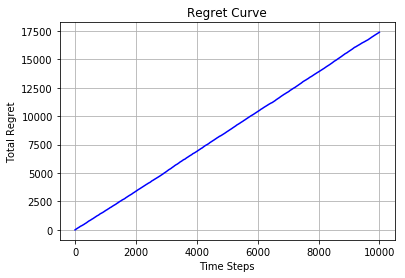

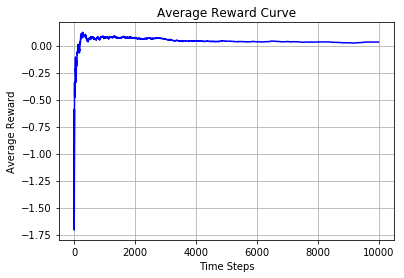

In [19]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : random_action_selection, # Action selection strategy (which function we are using )
                 "update_rule"       : update_rule # The update rule
                 }
estimates_rand, total_reward_rand, mean_rewards_rand, regret_rand = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, estimates_rand, total_reward_rand, mean_rewards_rand, regret_rand)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66990157 -0.01107028  0.68102879 -1.21163338  0.98971126 -1.0324365
  1.79218754 -0.279824   -1.27052304 -0.20216227]

Euclidean distance from q_star vector: 0.08873483092708691
Total Reward: 328.52366056315367
Mean Reward: 0.03285236605631531


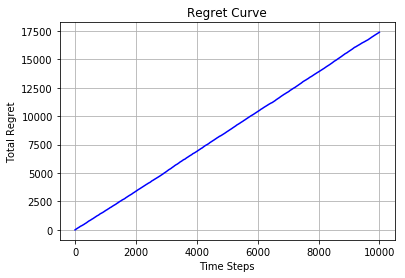

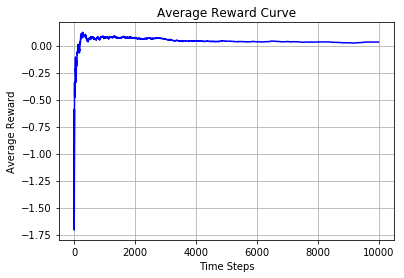

In [20]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : random_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
min_estimates_rand, min_total_reward_rand, min_mean_rewards_rand, min_regret_rand = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, min_estimates_rand, min_total_reward_rand, min_mean_rewards_rand, min_regret_rand)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66990157 -0.01107028  0.68102879 -1.21163338  0.98971126 -1.0324365
  1.79218754 -0.279824   -1.27052304 -0.20216227]

Euclidean distance from q_star vector: 0.08873483092708691
Total Reward: 328.52366056315367
Mean Reward: 0.03285236605631531


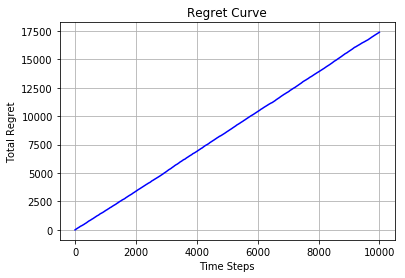

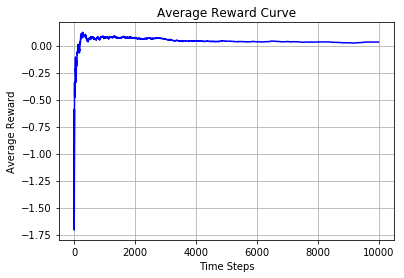

In [21]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : random_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_rand, avg_total_reward_rand, avg_mean_rewards_rand, avg_regret_rand = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_rand, avg_total_reward_rand, avg_mean_rewards_rand, avg_regret_rand)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66990157 -0.01107028  0.68102879 -1.21163338  0.98971126 -1.0324365
  1.79218754 -0.279824   -1.27052304 -0.20216227]

Euclidean distance from q_star vector: 0.08873483092708691
Total Reward: 328.52366056315367
Mean Reward: 0.03285236605631531


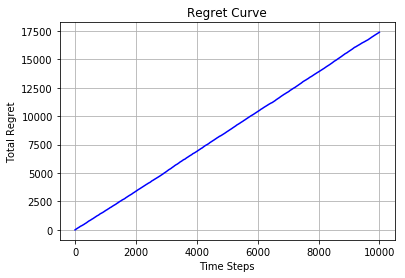

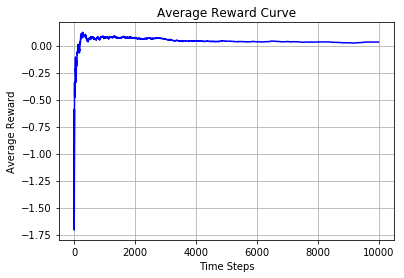

In [22]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : random_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
max_estimates_rand, max_total_reward_rand, max_mean_rewards_rand, max_regret_rand = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_rand, max_total_reward_rand, max_mean_rewards_rand, max_regret_rand)

#### Initializing with Random
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66990157 -0.01107028  0.68102879 -1.21163338  0.98971126 -1.0324365
  1.79218754 -0.279824   -1.27052304 -0.20216227]

Euclidean distance from q_star vector: 0.08873483092708691
Total Reward: 328.52366056315367
Mean Reward: 0.03285236605631531


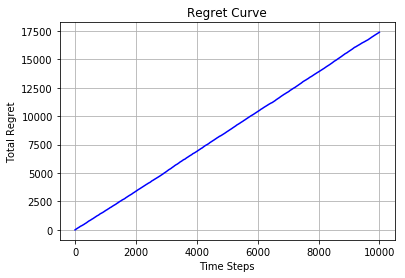

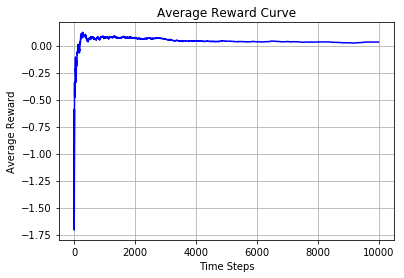

In [23]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : random_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

rnd_estimates_rand, rnd_total_reward_rand, rnd_mean_rewards_rand, rnd_regret_rand = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_rand, rnd_total_reward_rand, rnd_mean_rewards_rand, rnd_regret_rand)

#### Compare all:

Let's see a comparison between the different initialization strategies for the random action selection strategy:

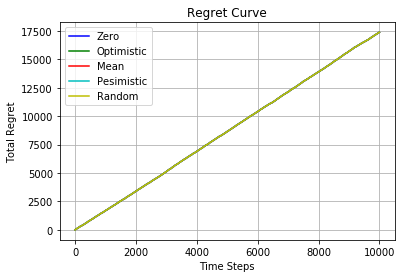

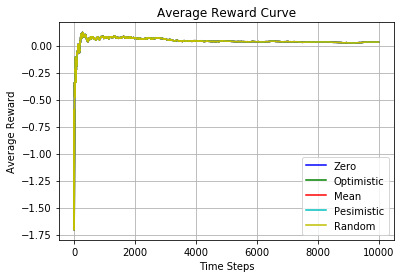

In [24]:
comp_plot(regret_rand, min_regret_rand, avg_regret_rand, max_regret_rand, rnd_regret_rand, \
          mean_rewards_rand, min_mean_rewards_rand, avg_mean_rewards_rand, max_mean_rewards_rand, rnd_mean_rewards_rand)

## 2.2. The bandit algorithm with greedy action selection and true average update

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [0.64532515 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

Euclidean distance from q_star vector: 2.957255018838588
Total Reward: 6453.251482706731
Mean Reward: 0.6453251482706759


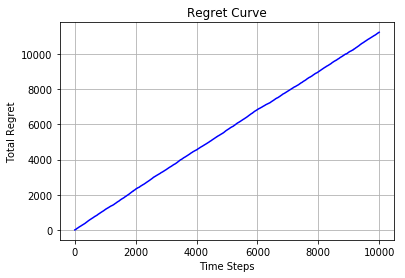

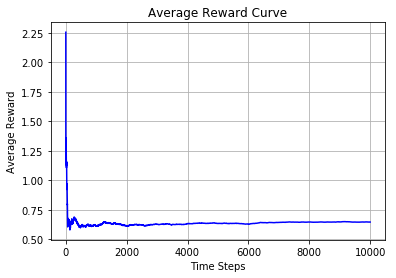

In [25]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

estimates_greedy, total_reward_greedy, mean_rewards_greedy, regret_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))                 
plot_bandits(N, estimates_greedy, total_reward_greedy, mean_rewards_greedy, regret_greedy)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.64532515 -1.25240742 -1.25240742 -1.25240742 -1.25240742 -1.25240742
 -1.25240742 -1.25240742 -1.25240742 -1.25240742]

Euclidean distance from q_star vector: 4.679383803413855
Total Reward: 6453.251482706731
Mean Reward: 0.6453251482706759


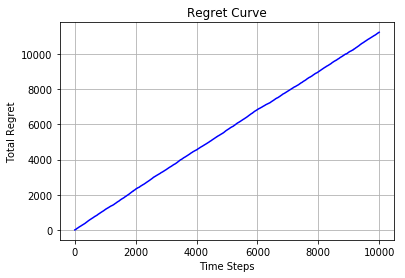

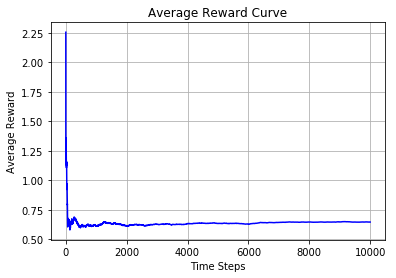

In [26]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

min_estimates_greedy, min_total_reward_greedy, min_mean_rewards_greedy, min_regret_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, min_estimates_greedy, min_total_reward_greedy, min_mean_rewards_greedy, min_regret_greedy)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [0.64532515 0.0243902  0.0243902  0.0243902  0.0243902  0.0243902
 0.0243902  0.0243902  0.0243902  0.0243902 ]

Euclidean distance from q_star vector: 2.96133633070318
Total Reward: 6453.251482706731
Mean Reward: 0.6453251482706759


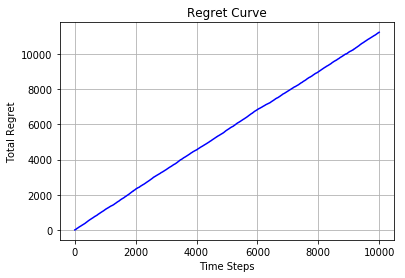

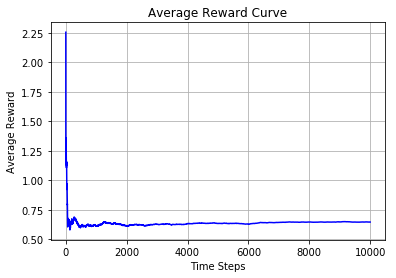

In [27]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_greedy, avg_total_reward_greedy, avg_mean_rewards_greedy, avg_regret_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_greedy, avg_total_reward_greedy, avg_mean_rewards_greedy, avg_regret_greedy)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 1.23313086  0.96481903  1.134417   -1.49741635  1.60632518  0.31983784
  1.78533957 -1.31268187 -1.38345957 -0.94102019]

Euclidean distance from q_star vector: 2.30226132581136
Total Reward: 17835.72080091897
Mean Reward: 1.7835720800918964


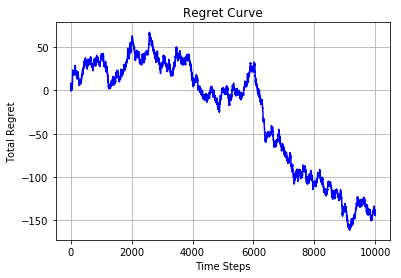

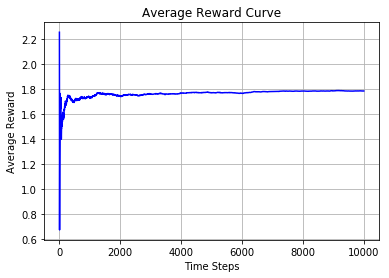

In [28]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

max_estimates_greedy, max_total_reward_greedy, max_mean_rewards_greedy, max_regret_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_greedy, max_total_reward_greedy, max_mean_rewards_greedy, max_regret_greedy)

#### Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [-0.1523881  -0.35554975 -0.22870344 -0.81669109 -0.08008135 -0.78293716
  0.14809652 -0.57646077 -0.77281507 -0.46098819]

Euclidean distance from q_star vector: 2.456009196184527
Total Reward: 11321.487011429237
Mean Reward: 1.132148701142928


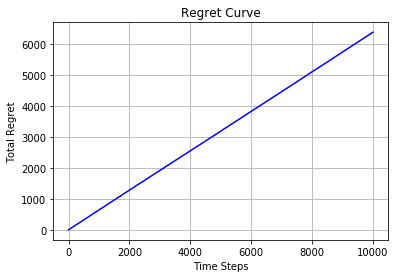

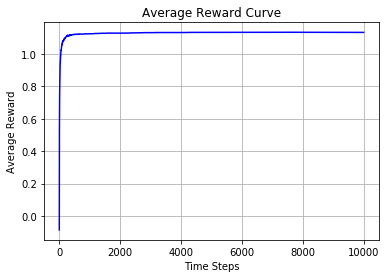

In [29]:
trials = 100

rnd_estimates_greedy = np.zeros(k)
rnd_total_reward_greedy = 0
rnd_mean_rewards_greedy = np.zeros(N)
rnd_regret_greedy = np.zeros(N)

for i in range(trials):
    bandit_inputs = {"k"             : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

    i_estimates_greedy, i_total_reward_greedy, i_mean_rewards_greedy, i_regret_greedy = bandit(bandit_inputs, i)
    rnd_estimates_greedy += i_estimates_greedy
    rnd_total_reward_greedy += i_total_reward_greedy
    rnd_mean_rewards_greedy += i_mean_rewards_greedy
    rnd_regret_greedy += i_regret_greedy
    #print(rnd_regret_greedy)

rnd_estimates_greedy /= trials
rnd_total_reward_greedy /= trials
rnd_mean_rewards_greedy /= trials
rnd_regret_greedy /= trials
print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_greedy, rnd_total_reward_greedy, rnd_mean_rewards_greedy, rnd_regret_greedy)

#### Compare all:

Let's see a comparison between the different initialization strategies for the random action selection strategy:

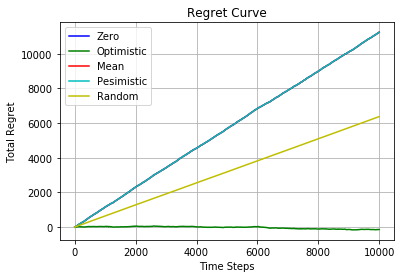

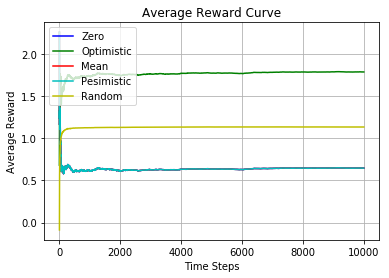

In [30]:
comp_plot(regret_greedy, min_regret_greedy, avg_regret_greedy, max_regret_greedy, rnd_regret_greedy, \
          mean_rewards_greedy, min_mean_rewards_greedy, avg_mean_rewards_greedy, max_mean_rewards_greedy, \
          rnd_mean_rewards_greedy)

## e-Greedy action selection strategy

### Test out different epsilon values. (Especially the limit cases 0, 1)

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.52605284 -0.01592887  0.67675947 -1.08823929  0.9913735  -1.15299068
  1.76385706 -0.24943073 -1.14550842 -0.20871778]

Euclidean distance from q_star vector: 0.23965591813421785
Total Reward: 15722.773082155129
Mean Reward: 1.5722773082155166


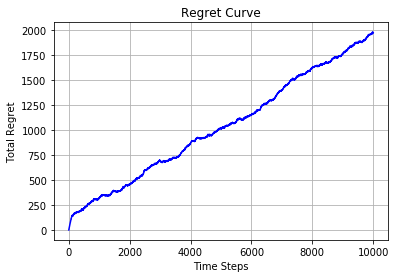

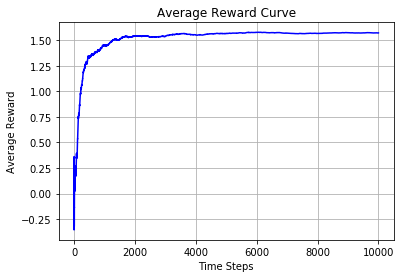

In [31]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "epsilon"           : 0.1, # Epsilon parameter 
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : e_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

estimates_e_greedy, total_reward_e_greedy, mean_rewards_e_greedy, regret_e_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, estimates_e_greedy, total_reward_e_greedy, mean_rewards_e_greedy, regret_e_greedy)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.5144317  -0.01193472  0.76935771 -1.08823929  0.9913735  -1.15299068
  1.76385706 -0.24943073 -1.14550842 -0.20871778]

Euclidean distance from q_star vector: 0.25500915097265947
Total Reward: 15717.026364627547
Mean Reward: 1.5717026364627569


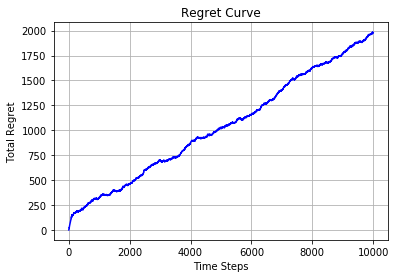

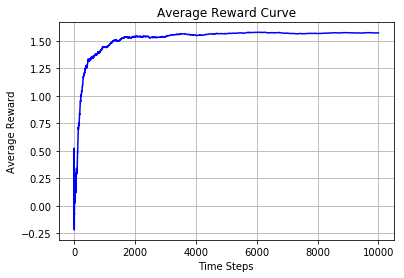

In [32]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "epsilon"           : 0.1,
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : e_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

min_estimates_e_greedy, min_total_reward_e_greedy, min_mean_rewards_e_greedy, min_regret_e_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, min_estimates_e_greedy, min_total_reward_e_greedy, min_mean_rewards_e_greedy, min_regret_e_greedy)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.52605284 -0.01592887  0.67675947 -1.08823929  0.9913735  -1.15299068
  1.76385706 -0.24943073 -1.14550842 -0.20871778]

Euclidean distance from q_star vector: 0.23965591813421785
Total Reward: 15722.773082155129
Mean Reward: 1.5722773082155166


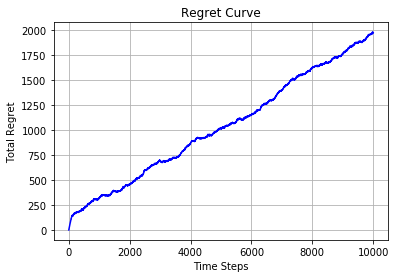

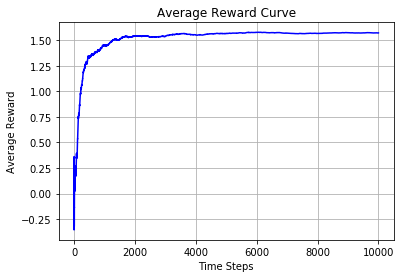

In [33]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "epsilon"           : 0.1,
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : e_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_e_greedy, avg_total_reward_e_greedy, avg_mean_rewards_e_greedy, avg_regret_e_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_e_greedy, avg_total_reward_e_greedy, avg_mean_rewards_e_greedy, avg_regret_e_greedy)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.52605284 -0.00604807  0.75902463 -1.08497107  0.93650895 -1.14066638
  1.76368349 -0.24932015 -1.14687026 -0.20871778]

Euclidean distance from q_star vector: 0.2504058345303939
Total Reward: 15745.10280065239
Mean Reward: 1.5745102800652488


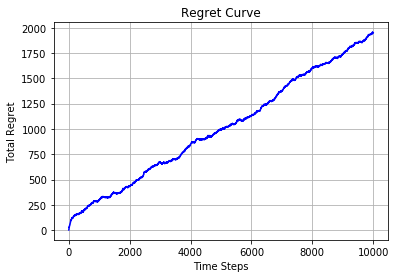

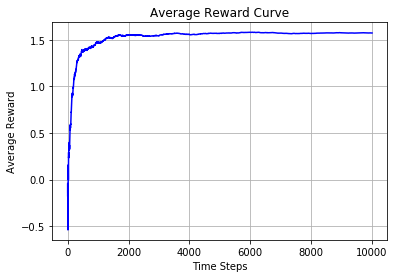

In [34]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "epsilon"           : 0.1,
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : e_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

max_estimates_e_greedy, max_total_reward_e_greedy, max_mean_rewards_e_greedy, max_regret_e_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_e_greedy, max_total_reward_e_greedy, max_mean_rewards_e_greedy, max_regret_e_greedy)

#### Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.53489337 -0.00704625  0.76935771 -1.08823929  0.97933971 -1.15299068
  1.76259473 -0.24943073 -1.14550842 -0.20871778]

Euclidean distance from q_star vector: 0.24671835368717046
Total Reward: 15816.669699377206
Mean Reward: 1.581666969937732


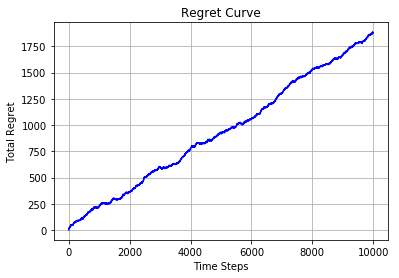

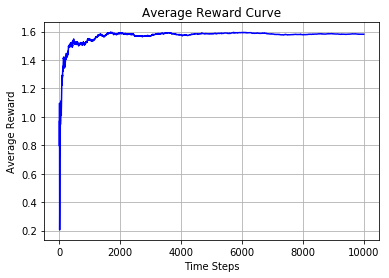

In [35]:
trials = 100

rnd_estimates_e_greedy = np.zeros(k)
rnd_total_reward_e_greedy = 0
rnd_mean_rewards_e_greedy = np.zeros(N)
rnd_regret_e_greedy = np.zeros(N)

for i in range(trials):
    bandit_inputs = {"k"             : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "epsilon"           : 0.1,
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : e_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
    i_estimates_e_greedy, i_total_reward_e_greedy, i_mean_rewards_e_greedy, i_regret_e_greedy = bandit(bandit_inputs)
    rnd_estimates_e_greedy += i_estimates_e_greedy
    rnd_total_reward_e_greedy += i_total_reward_e_greedy
    rnd_mean_rewards_e_greedy += i_mean_rewards_e_greedy
    rnd_regret_e_greedy += i_regret_e_greedy

rnd_estimates_e_greedy /= trials
rnd_total_reward_e_greedy /= trials
rnd_mean_rewards_e_greedy /= trials
rnd_regret_e_greedy /= trials
print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_e_greedy, rnd_total_reward_e_greedy, rnd_mean_rewards_e_greedy, rnd_regret_e_greedy)

#### Compare all:

Let's see a comparison between the different initialization strategies for the e-greedy action selection strategy:

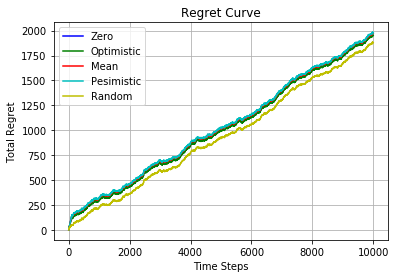

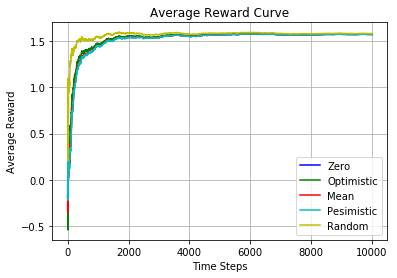

In [36]:
comp_plot(regret_e_greedy, min_regret_e_greedy, avg_regret_e_greedy, max_regret_e_greedy, rnd_regret_e_greedy, \
          mean_rewards_e_greedy, min_mean_rewards_e_greedy, avg_mean_rewards_e_greedy, max_mean_rewards_e_greedy, \
          rnd_mean_rewards_e_greedy)

## e-Greedy with epsilon decay action selection strategy

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.74014287 -0.42119936  0.64527201 -1.61149906  1.07635362 -0.81967354
  1.7688918  -0.31125471 -0.79974387 -1.1143414 ]

Euclidean distance from q_star vector: 1.2378076992449736
Total Reward: 17399.232257172454
Mean Reward: 1.7399232257172483


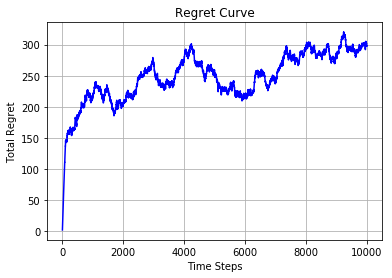

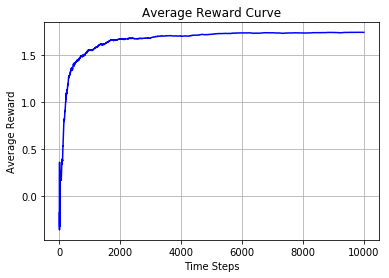

In [37]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "kappa"             : 0.001, # Decay coefficient
                 "epsilon"           : 0.1,  # The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

estimates_e_decay_greedy, total_reward_e_decay_greedy, mean_rewards_e_decay_greedy, regret_e_decay_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, estimates_e_decay_greedy, total_reward_e_decay_greedy, mean_rewards_e_decay_greedy, regret_e_decay_greedy)

### Test out different epsilon, min_epsilon and kappa values. (Especially the limit cases 0, 1)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.52983163 -0.39078239  1.33449247 -1.61149906  1.07635362 -0.81967354
  1.76897591 -0.31125471 -0.79974387 -1.1143414 ]

Euclidean distance from q_star vector: 1.3825033088669407
Total Reward: 17392.408961711008
Mean Reward: 1.7392408961711099


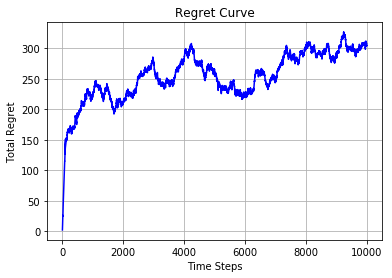

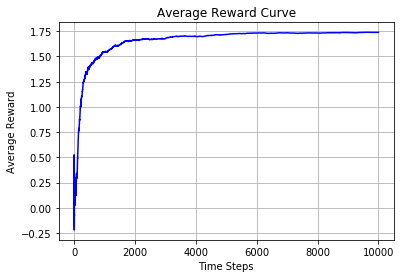

In [38]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "kappa"             : 0.001, # Decay coefficient
                 "epsilon"           : 0.1,  # The epsilon parameter.
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

min_estimates_e_decay_greedy, min_total_reward_e_decay_greedy, min_mean_rewards_e_decay_greedy, min_regret_e_decay_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))                 
plot_bandits(N, min_estimates_e_decay_greedy, min_total_reward_e_decay_greedy, min_mean_rewards_e_decay_greedy, min_regret_e_decay_greedy)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.74014287 -0.42119936  0.64527201 -1.61149906  1.07635362 -0.81967354
  1.7688918  -0.31125471 -0.79974387 -1.1143414 ]

Euclidean distance from q_star vector: 1.2378076992449736
Total Reward: 17399.232257172454
Mean Reward: 1.7399232257172483


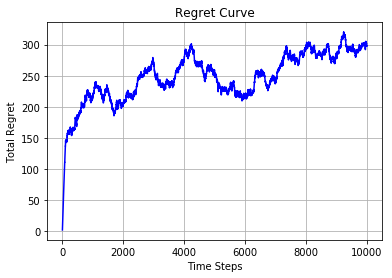

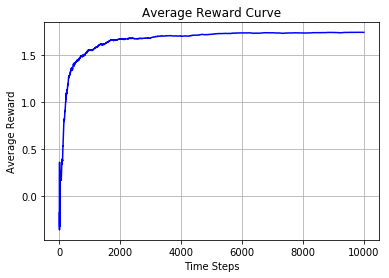

In [39]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "kappa"             : 0.001, # Decay coefficient
                 "epsilon"           : 0.1,  # The epsilon parameter.
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_e_decay_greedy, avg_total_reward_e_decay_greedy, avg_mean_rewards_e_decay_greedy, avg_regret_e_decay_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_e_decay_greedy, avg_total_reward_e_decay_greedy, avg_mean_rewards_e_decay_greedy, avg_regret_e_decay_greedy)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.74014287 -0.37427868  1.31193741 -1.51414041  0.89911945 -0.70355324
  1.76873258 -0.30663042 -0.84793875 -1.1143414 ]

Euclidean distance from q_star vector: 1.3501086499714914
Total Reward: 17421.56197566971
Mean Reward: 1.7421561975669762


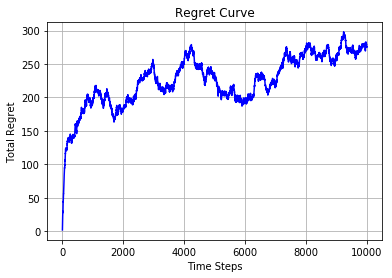

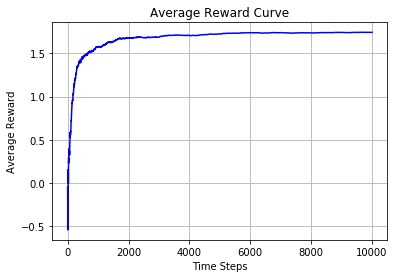

In [40]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "kappa"             : 0.001, # Decay coefficient
                 "epsilon"           : 0.1,  # The epsilon parameter.
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

max_estimates_e_decay_greedy, max_total_reward_e_decay_greedy, max_mean_rewards_e_decay_greedy, max_regret_e_decay_greedy = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_e_decay_greedy, max_total_reward_e_decay_greedy, max_mean_rewards_e_decay_greedy, max_regret_e_decay_greedy)

#### Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.80535243 -0.41655632  1.33449247 -1.61149906  0.96847628 -0.81967354
  1.76778587 -0.31125471 -0.79974387 -1.1143414 ]

Euclidean distance from q_star vector: 1.3976054484576315
Total Reward: 17493.192726811558
Mean Reward: 1.7493192726811528


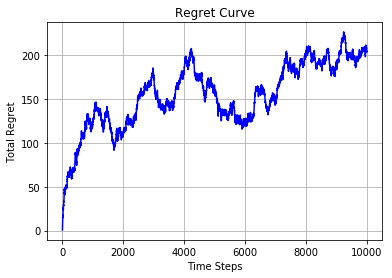

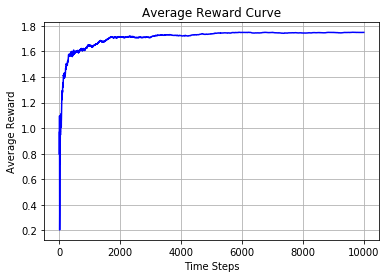

In [41]:
trials = 100

rnd_estimates_e_decay_greedy = np.zeros(k)
rnd_total_reward_e_decay_greedy = 0
rnd_mean_rewards_e_decay_greedy = np.zeros(N)
rnd_regret_e_decay_greedy = np.zeros(N)

for i in range(trials):
    bandit_inputs = {"k"             : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "kappa"             : 0.001, # Decay coefficient
                 "epsilon"           : 0.1,  # The epsilon parameter.
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
    i_estimates_e_decay_greedy, i_total_reward_e_decay_greedy, i_mean_rewards_e_decay_greedy, i_regret_e_decay_greedy = bandit(bandit_inputs)
    rnd_estimates_e_decay_greedy += i_estimates_e_decay_greedy
    rnd_total_reward_e_decay_greedy += i_total_reward_e_decay_greedy
    rnd_mean_rewards_e_decay_greedy += i_mean_rewards_e_decay_greedy
    rnd_regret_e_decay_greedy += i_regret_e_decay_greedy

rnd_estimates_e_decay_greedy /= trials
rnd_total_reward_e_decay_greedy /= trials
rnd_mean_rewards_e_decay_greedy /= trials
rnd_regret_e_decay_greedy /= trials
print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_e_decay_greedy, rnd_total_reward_e_decay_greedy, rnd_mean_rewards_e_decay_greedy, rnd_regret_e_decay_greedy)

#### Compare all:

Let's see a comparison between the different initialization strategies for the e-Greedy with epsilon decay action selection strategy:

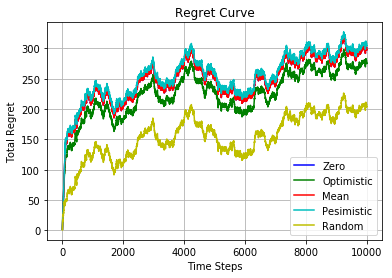

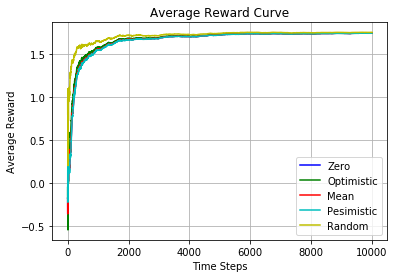

In [42]:
comp_plot(regret_e_decay_greedy, min_regret_e_decay_greedy, avg_regret_e_decay_greedy,\
          max_regret_e_decay_greedy, rnd_regret_e_decay_greedy, mean_rewards_e_decay_greedy,\
          min_mean_rewards_e_decay_greedy, avg_mean_rewards_e_decay_greedy,\
          max_mean_rewards_e_decay_greedy, rnd_mean_rewards_e_decay_greedy)

## Upper Confidence Bound action selection strategy

### Test out different c values.

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.86101688  0.32642037  0.65224513 -1.20182704  0.88361234 -0.59713894
  1.78521269 -0.18160476 -1.04790649 -0.71897089]

Euclidean distance from q_star vector: 0.8145319558253483
Total Reward: 17664.025671141262
Mean Reward: 1.7664025671141146


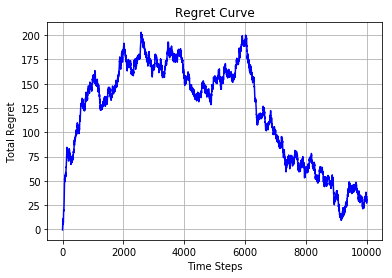

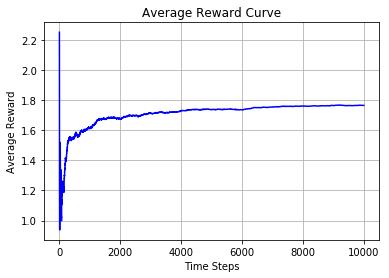

In [43]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "c"                 : 2., # The c parameter
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : ucb_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

estimates_ucb, total_reward_ucb, mean_rewards_ucb, regret_ucb = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, estimates_ucb, total_reward_ucb, mean_rewards_ucb, regret_ucb)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.87827322  0.14277489  0.69198822 -0.59027536  0.837023   -0.88521409
  1.78531814 -0.09686993 -2.81275952 -0.69168443]

Euclidean distance from q_star vector: 1.7889197307473408
Total Reward: 17669.841222190396
Mean Reward: 1.7669841222190374


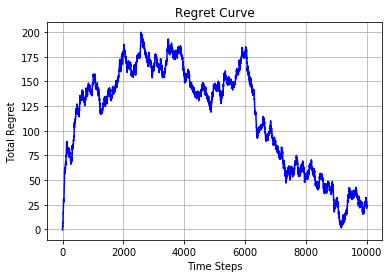

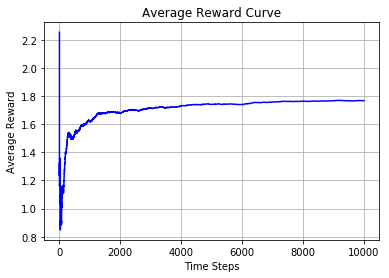

In [44]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "c"                 : 2., # The c parameter
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : ucb_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

min_estimates_ucb, min_total_reward_ucb, min_mean_rewards_ucb, min_regret_ucb = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, min_estimates_ucb, min_total_reward_ucb, min_mean_rewards_ucb, min_regret_ucb)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.80040773  0.11162252  0.51909702 -0.89032711  1.07705698 -0.7360993
  1.78468068  0.01074362 -1.77433378 -0.08786916]

Euclidean distance from q_star vector: 0.7709345654311386
Total Reward: 17649.39861846453
Mean Reward: 1.7649398618464436


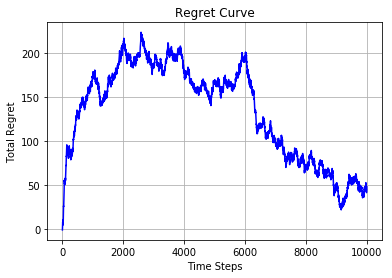

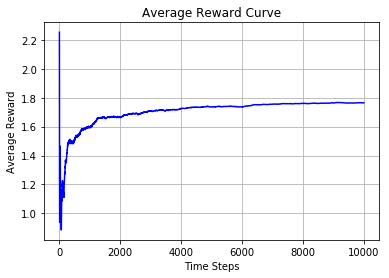

In [45]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "c"                 : 2., # The c parameter
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : ucb_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_ucb, avg_total_reward_ucb, avg_mean_rewards_ucb, avg_regret_ucb = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_ucb, avg_total_reward_ucb, avg_mean_rewards_ucb, avg_regret_ucb)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.51323204  0.26196749  0.80549514 -1.83990167  0.5977245  -0.36179601
  1.78611544 -0.63840914 -0.82868483 -0.19109786]

Euclidean distance from q_star vector: 1.186250602354012
Total Reward: 17689.109960523605
Mean Reward: 1.7689109960523604


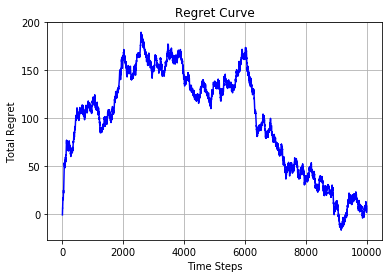

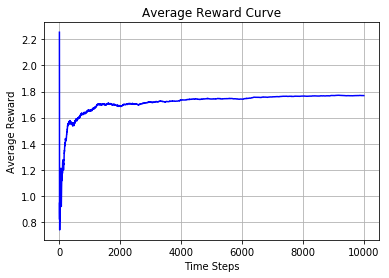

In [46]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "c"                 : 2., # The c parameter
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : ucb_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

max_estimates_ucb, max_total_reward_ucb, max_mean_rewards_ucb, max_regret_ucb = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_ucb, max_total_reward_ucb, max_mean_rewards_ucb, max_regret_ucb)

#### Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.43737425  0.3923647   0.61516529 -1.00601275  0.95066676 -0.87244335
  1.78519122 -0.02223897 -0.59441194  0.03587991]

Euclidean distance from q_star vector: 0.8734697660157612
Total Reward: 17660.1095876319
Mean Reward: 1.7660109587631914


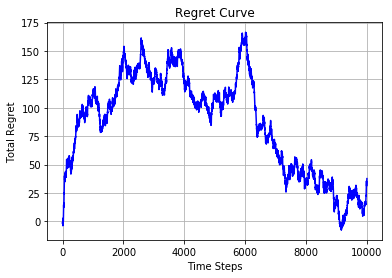

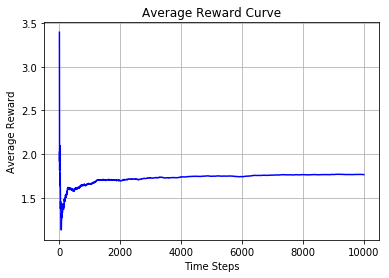

In [47]:
trials = 100

rnd_estimates_ucb = np.zeros(k)
rnd_total_reward_ucb = 0
rnd_mean_rewards_ucb = np.zeros(N)
rnd_regret_ucb = np.zeros(N)

for i in range(trials):
    bandit_inputs = {"k"             : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "c"                 : 2., # The c parameter
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : ucb_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
    i_estimates_ucb, i_total_reward_ucb, i_mean_rewards_ucb, i_regret_ucb = bandit(bandit_inputs)
    rnd_estimates_ucb += i_estimates_ucb
    rnd_total_reward_ucb += i_total_reward_ucb
    rnd_mean_rewards_ucb += i_mean_rewards_ucb
    rnd_regret_ucb += i_regret_ucb

rnd_estimates_ucb /= trials
rnd_total_reward_ucb /= trials
rnd_mean_rewards_ucb /= trials
rnd_regret_ucb /= trials
print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_ucb, rnd_total_reward_ucb, rnd_mean_rewards_ucb, rnd_regret_ucb)

#### Compare all:

Let's see a comparison between the different initialization strategies for the ucb action selection strategy:

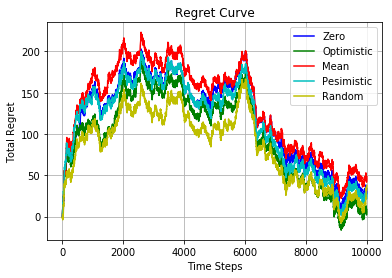

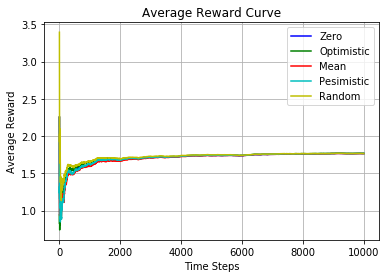

In [48]:
comp_plot(regret_ucb, min_regret_ucb, avg_regret_ucb, max_regret_ucb, rnd_regret_ucb, \
          mean_rewards_ucb, min_mean_rewards_ucb, avg_mean_rewards_ucb, max_mean_rewards_ucb, \
          rnd_mean_rewards_ucb)

# Softmax action selection strategy

### Test out different tau values. What happens very close to 0 and with very high tau values? Try to find a good tau parameter!

#### Initializing with zero values:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [-3.32722123  0.05134809  0.7372469  -1.08502233  1.00527099 -1.39793715
  1.76013937 -0.30266221 -1.96297586 -0.16130325]

Euclidean distance from q_star vector: 4.040023137843064
Total Reward: 14425.088143501836
Mean Reward: 1.4425088143501827


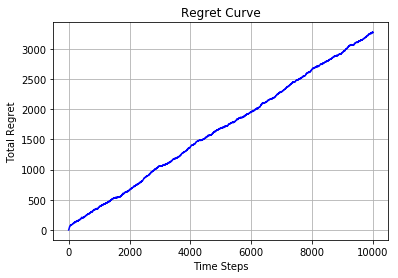

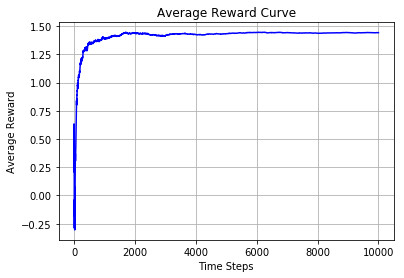

In [49]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "tau"               : 0.5, # The tau parameter
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : softmax_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

estimates_sm, total_reward_sm, mean_rewards_sm, regret_sm = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, estimates_sm, total_reward_sm, mean_rewards_sm, regret_sm)

#### Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.66618078  0.08198115  0.65068393 -2.74299812  1.04503328 -1.01545038
  1.75344036 -0.335129   -1.15352028 -0.13130751]

Euclidean distance from q_star vector: 1.5643251713052473
Total Reward: 14153.208577004594
Mean Reward: 1.4153208577004521


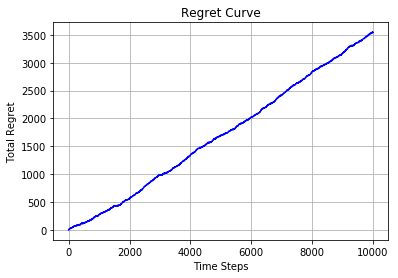

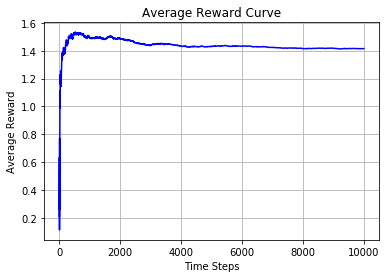

In [50]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "tau"               : 0.5, # The tau parameter
                 "initialization"    : MinInitialization, # Initialization strategy
                 "action_selection"  : softmax_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

min_estimates_sm, min_total_reward_sm, min_mean_rewards_sm, min_regret_sm = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, min_estimates_sm, min_total_reward_sm, min_mean_rewards_sm, min_regret_sm)

#### Initializing with Mean:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [-3.32722123  0.05134809  0.7372469  -1.08502233  1.00527099 -1.39793715
  1.76013937 -0.30266221 -1.96297586 -0.16130325]

Euclidean distance from q_star vector: 4.040023137843064
Total Reward: 14425.088143501836
Mean Reward: 1.4425088143501827


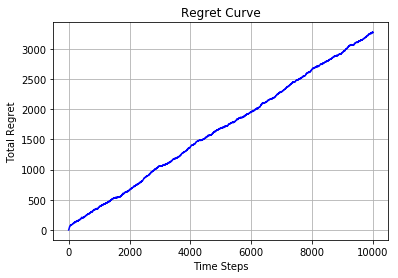

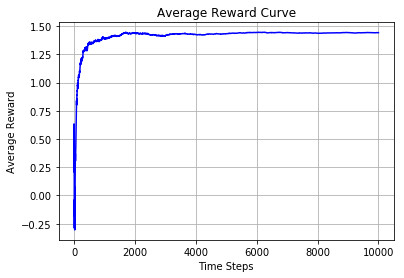

In [51]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "tau"               : 0.5, # The tau parameter
                 "initialization"    : MeanInitialization, # Initialization strategy
                 "action_selection"  : softmax_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

avg_estimates_sm, avg_total_reward_sm, avg_mean_rewards_sm, avg_regret_sm = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, avg_estimates_sm, avg_total_reward_sm, avg_mean_rewards_sm, avg_regret_sm)

#### Initializing with Optimistic:
What do you think the expected reward is?

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.67813064  0.05732141  0.69087554 -1.29144763  1.03317673 -1.67112306
  1.75522729 -0.32449082 -1.19372117 -0.13931594]

Euclidean distance from q_star vector: 0.6758514660579348
Total Reward: 14074.942563817149
Mean Reward: 1.4074942563817192


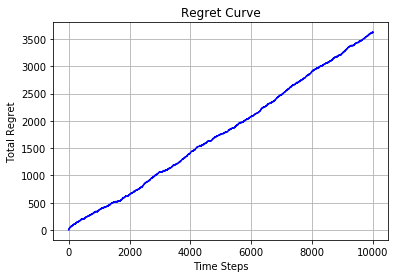

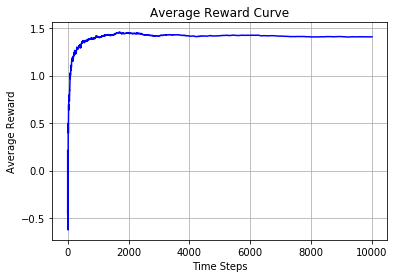

In [52]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "tau"               : 0.5, # The tau parameter
                 "initialization"    : MaxInitialization, # Initialization strategy
                 "action_selection"  : softmax_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }

max_estimates_sm, max_total_reward_sm, max_mean_rewards_sm, max_regret_sm = bandit(bandit_inputs)
print("True q values:{}".format(q_star))
plot_bandits(N, max_estimates_sm, max_total_reward_sm, max_mean_rewards_sm, max_regret_sm)

#### Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [ 0.67709057  0.05818345  0.69220284 -1.66214988  1.03272267 -2.3015387
  1.75450196 -0.42845837 -0.93965211 -0.11146466]

Euclidean distance from q_star vector: 1.4212327278398176
Total Reward: 14178.631830883443
Mean Reward: 1.417863183088343


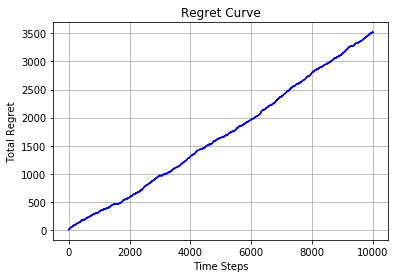

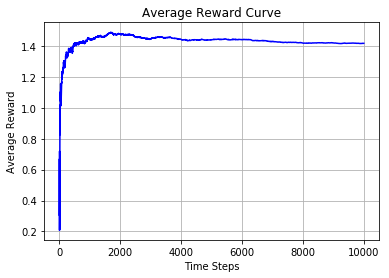

In [53]:
trials = 100

rnd_estimates_sm = np.zeros(k)
rnd_total_reward_sm = 0
rnd_mean_rewards_sm = np.zeros(N)
rnd_regret_sm = np.zeros(N)

for i in range(trials):
    bandit_inputs = {"k"             : k, # Number of coffee shops
                 "k_t"               : np.zeros(k), # The coffee shop selection counter
                 "N"                 : N, # Number of trials
                 "q_star"            : q_star, # The true unknown rewards
                 "tau"               : 0.5, # The tau parameter
                 "initialization"    : RandomInitialization, # Initialization strategy
                 "action_selection"  : softmax_action_selection, # Action selection strategy
                 "update_rule"       : update_rule # The update rule
                 }
    i_estimates_sm, i_total_reward_sm, i_mean_rewards_sm, i_regret_sm = bandit(bandit_inputs)
    rnd_estimates_sm += i_estimates_sm
    rnd_total_reward_sm += i_total_reward_sm
    rnd_mean_rewards_sm += i_mean_rewards_sm
    rnd_regret_sm += i_regret_sm

rnd_estimates_sm /= trials
rnd_total_reward_sm /= trials
rnd_mean_rewards_sm /= trials
rnd_regret_sm /= trials

print("True q values:{}".format(q_star))
plot_bandits(N, rnd_estimates_sm, rnd_total_reward_sm, rnd_mean_rewards_sm, rnd_regret_sm)

#### Compare all:

Let's see a comparison between the different initialization strategies for the softmax action selection strategy:

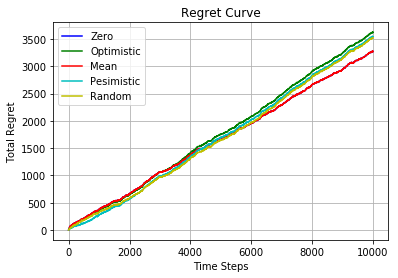

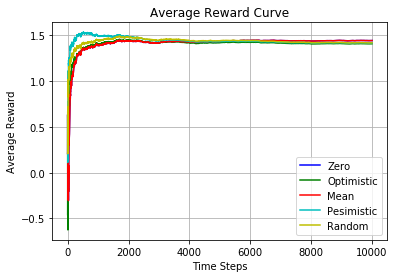

In [54]:
comp_plot(regret_sm, min_regret_sm, avg_regret_sm, max_regret_sm, rnd_regret_sm, \
          mean_rewards_sm, min_mean_rewards_sm, avg_mean_rewards_sm, max_mean_rewards_sm, \
          rnd_mean_rewards_sm)

## Gradient bandits

## Exercise 1: Implement the gradient bandits action selection and update rule methods yourself:

In [55]:
def gradient_bandit_action_selection(estimates, bandit_inputs, t):
    # gradient action selection
    action = np.random.choice(bandit_inputs["k"], 1, \
                              p=np.exp(estimates) / np.sum(np.exp(estimates)))
    return action[0]


def gradient_bandit_update_rule(estimates, coffee_shop, reward, bandit_inputs, mean_reward=None):
    
    bias = bandit_inputs["bias"]
    if (bias == True) :
        bias = mean_reward
    else :
        bias = 0
    
    normalize = np.sum(estimates)
    # Update the estimates
    estimates[coffee_shop] = estimates[coffee_shop] + bandit_inputs["lr"] * (reward - bias) * (1 - coffee_shop) / normalize
    
    for i in range(k) :
        if (i != coffee_shop) :
            estimates[coffee_shop] = estimates[coffee_shop] - bandit_inputs["lr"] * (reward - mean_reward) * (coffee_shop)/normalize            
    
    return estimates

#### Run the gradient bandits with zeros initialization:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


True q values:[ 0.6293371   0.04522394  0.69318951 -1.18563268  1.01204552 -1.01174866
  1.76976745 -0.27503869 -1.25240742 -0.18083404]
Learned Estimates: [nan  0.  0.  0. nan  0.  0.  0.  0.  0.]

Euclidean distance from q_star vector: nan
Total Reward: 6251.980556899607
Mean Reward: 0.6251980556899603


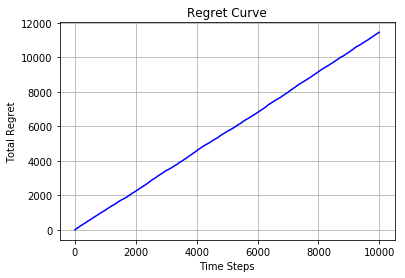

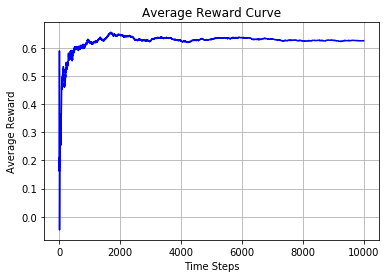

In [56]:
bandit_inputs = {"k"                 : k, # Number of coffee shops
                 "lr"                : 4., # Learning rate
                 "bias"              : True, # Bias (mean values)
                 "N"                 : N, # Number of trials
                 "k_t"               : np.zeros(k), # NOT NEEDED IN GRADIENT--- KEPT HERE TO HAVE THE SAME GENERAL ALGO
                 "q_star"            : q_star, # The true unknown rewards
                 "initialization"    : ZeroInitialization, # Initialization strategy
                 "action_selection"  : gradient_bandit_action_selection, # Action selection strategy
                 "update_rule"       : gradient_bandit_update_rule # The update rule
                }

estimates_grd, total_reward_grd, mean_rewards_grd, regret_grd = bandit(bandit_inputs)
print("True q values:{}".format(q_star))                 
plot_bandits(N, estimates_grd, total_reward_grd, mean_rewards_grd, regret_grd)

#### Will gradient bandits have a different result using other initializations?
Run the gradient bandits using different initializations to find out if you were correct:

## Comparing Bandit Algorithms
Compare the bandit algorithms through plotting.

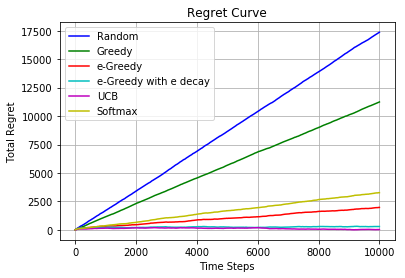

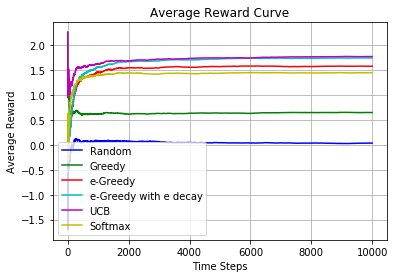

In [57]:
### Plot the results of all the algorithms ###
##############################################

fig, ax = plt.subplots()
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_rand), 'b-')
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_greedy), 'g-')
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_e_greedy), 'r-')
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_e_decay_greedy), 'c-')
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_ucb), 'm-')
ax.plot(np.linspace(0,N-1,N), np.cumsum(regret_sm), 'y-')
ax.set_xlabel("Time")
ax.set_ylabel("Speed")
ax.grid()
ax.set(xlabel='Time Steps', ylabel='Total Regret',
       title='Regret Curve')
plt.legend(['Random','Greedy','e-Greedy','e-Greedy with e decay','UCB','Softmax'])
plt.show()

fig, ax = plt.subplots()
ax.plot(np.linspace(0,N-1,N), mean_rewards_rand, 'b-')
ax.plot(np.linspace(0,N-1,N), mean_rewards_greedy, 'g-')
ax.plot(np.linspace(0,N-1,N), mean_rewards_e_greedy, 'r-')
ax.plot(np.linspace(0,N-1,N), mean_rewards_e_decay_greedy, 'c-')
ax.plot(np.linspace(0,N-1,N), mean_rewards_ucb, 'm-')
ax.plot(np.linspace(0,N-1,N), mean_rewards_sm, 'y-')
ax.set_xlabel("Time")
ax.set_ylabel("Speed")
ax.grid()
ax.set(xlabel='Time Steps', ylabel='Average Reward',
       title='Average Reward Curve')
plt.legend(['Random','Greedy','e-Greedy','e-Greedy with e decay','UCB','Softmax'])
plt.show()

## Exercise 2: Implement a bandit of your own liking!
(A hybrid bandit maybe? play with constant step size? compare different greedy ones? different gradient-based ones?)
